In [ ]:
# Install necessary libraries
!pip install torch torchvision matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
# Assign the image directory
import os
data_directory = '/content/drive/MyDrive/Project/Dataset/training/HAPPY'

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt

# Define the Generator
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 64*64*3),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 3, 64, 64)
        return img

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64*64*3, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

# Hyperparameters
latent_dim = 100
learning_rate = 0.0002
batch_size = 64
n_epochs = 200

# Create a custom dataset class to load images
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, file) for file in os.listdir(root_dir) if file.endswith(('jpg', 'png'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image

# Define image transformations
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5], [0.5])
])

# Load your dataset
dataset = CustomDataset(root_dir=data_directory, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models and optimizers
generator = Generator(latent_dim)
discriminator = Discriminator()
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)
criterion = nn.BCELoss()


In [ ]:
# Training loop
for epoch in range(n_epochs):
    for i, imgs in enumerate(dataloader):
        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1)
        fake = torch.zeros(imgs.size(0), 1)

        # Configure input
        real_imgs = imgs

        # Train Discriminator
        optimizer_D.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim)
        gen_imgs = generator(z)
        real_loss = criterion(discriminator(real_imgs), valid)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        if i % 400 == 0:
            print(f'Epoch [{epoch}/{n_epochs}] Batch {i}/{len(dataloader)} \
                   Loss D: {d_loss.item()}, Loss G: {g_loss.item()}')

    # Save generated images
    os.makedirs('/content/drive/MyDrive/Project/GAN/generated images', exist_ok=True)
    save_image(gen_imgs.data[:25], f'/content/drive/MyDrive/Project/GAN/generated images/{epoch}.png', nrow=5, normalize=True)


Epoch [0/200] Batch 0/8                    Loss D: 1.3855855464935303, Loss G: 0.7047860622406006
Epoch [1/200] Batch 0/8                    Loss D: 0.7062010765075684, Loss G: 0.8332206606864929
Epoch [2/200] Batch 0/8                    Loss D: 0.7673768997192383, Loss G: 0.9857397079467773
Epoch [3/200] Batch 0/8                    Loss D: 1.507957935333252, Loss G: 0.7815918326377869
Epoch [4/200] Batch 0/8                    Loss D: 0.8765512704849243, Loss G: 2.069765329360962
Epoch [5/200] Batch 0/8                    Loss D: 0.41635972261428833, Loss G: 2.5255377292633057
Epoch [6/200] Batch 0/8                    Loss D: 0.34725987911224365, Loss G: 2.3537912368774414
Epoch [7/200] Batch 0/8                    Loss D: 0.3326939046382904, Loss G: 2.2673330307006836
Epoch [8/200] Batch 0/8                    Loss D: 0.1598113775253296, Loss G: 2.8127098083496094
Epoch [9/200] Batch 0/8                    Loss D: 0.07512923330068588, Loss G: 3.2949936389923096
Epoch [10/200] Batc

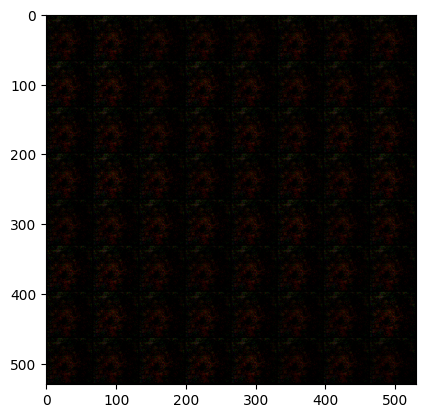

In [ ]:
import torchvision

# Generate synthetic images
generator.eval()
with torch.no_grad():
    z = torch.randn(64, latent_dim)
    gen_imgs = generator(z)
    save_image(gen_imgs.data, '/content/drive/MyDrive/Project/GAN/generated images/synthetic_images.png', nrow=8, normalize=True)

# Visualize some generated images
grid_img = torchvision.utils.make_grid(gen_imgs, nrow=8)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [ ]:
# Directory to save 10 generated images
generated_images_dir = '/content/drive/MyDrive/Project/GAN/Final output'
os.makedirs(generated_images_dir, exist_ok=True)

# Generate 10 synthetic images
generator.eval()
with torch.no_grad():
    for i in range(10):
        z = torch.randn(1, latent_dim, device=device)
        gen_img = generator(z)
        save_image(gen_img.data, f'{output_dir}/generated_image_{i+1}.png', normalize=True)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
# Visualize some generated images
with torch.no_grad():
    z = torch.randn(64, latent_dim, device=device)
    gen_imgs = generator(z)
    grid_img = make_grid(gen_imgs, nrow=8, normalize=True)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0).cpu())
    plt.axis('off')
    plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)